In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import optuna

import lightgbm as lgbm

from sklearn.metrics import mean_absolute_error

In [2]:
df = pd.read_csv('train_dataset.csv')[['date', 'time', 'target', 'temp_pred', 'weather_pred']]
df.head()

,date,time,target,temp_pred,weather_pred
0,2019-01-01,0,481.510,2.0,"пасм, ветер"
1,2019-01-01,1,462.872,2.0,"пасм, ветер"
2,2019-01-01,2,449.718,2.0,"пасм, ветер"
3,2019-01-01,3,430.908,2.0,"пасм, ветер"
4,2019-01-01,4,415.163,2.0,"пасм, ветер"


In [3]:
df.shape

(37224, 5)

In [4]:
#add features of day-of-week, day-of-month, week, month, season
df['date'] = pd.to_datetime(df['date']).dt.normalize()
df['dow'] = df['date'].dt.dayofweek
df['day'] = df['date'].dt.day
df['week'] = df['date'].dt.isocalendar().week.astype('int32')
df['month'] = df['date'].dt.month
df['season'] = df['date'].dt.quarter
df['year'] = df['date'].dt.year

In [5]:
#add lag columns
shifted = df.copy()

for i in range(24, (24*21+1)):
    shifted[f'target_lag_{int(i)}'] = shifted['target'].shift(i)
shifted.head()

,date,time,target,temp_pred,weather_pred,dow,day,week,month,season,...,target_lag_495,target_lag_496,target_lag_497,target_lag_498,target_lag_499,target_lag_500,target_lag_501,target_lag_502,target_lag_503,target_lag_504
0,2019-01-01,0,481.510,2.0,"пасм, ветер",1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01,1,462.872,2.0,"пасм, ветер",1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01,2,449.718,2.0,"пасм, ветер",1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01,3,430.908,2.0,"пасм, ветер",1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01,4,415.163,2.0,"пасм, ветер",1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#delete nans where there's no lag data (start of period)
shifted['na_sum'] = shifted.isna().sum(axis=1)
shifted = shifted[shifted['na_sum'] == 0]
shifted = shifted.drop('na_sum', axis=1)
shifted.shape

(36632, 492)

In [7]:
bad_weathers = {'пасм': 'overcast', 'дожд': 'rain', 'снег': 'snow', 'ливень': 'heavy_rain', 'гроз': 'thunder', 'шторм': 'storm'}
for weather_type in bad_weathers.keys():
    shifted[bad_weathers[weather_type]] = np.where(shifted['weather_pred'].str.contains(weather_type), 1, 0)

shifted['cloudy'] = np.where((shifted['weather_pred'].str.contains(' обл')) | (shifted['weather_pred'].str.startswith('обл')), 1, 0)

In [8]:
daylight = pd.read_csv('light_day.csv')
daylight.head()

,Дата,Начало рассвета,Восход,Заход,Наступление темноты,Долгота дня,Продолжительность ночи,Разница
0,2022-01-01,08:16,09:01,16:21,17:05,07:20,15:12,00:01
1,2022-01-02,08:16,09:00,16:22,17:06,07:22,15:11,00:02
2,2022-01-03,08:16,09:00,16:23,17:07,07:23,15:10,00:01
3,2022-01-04,08:16,09:00,16:24,17:08,07:24,15:09,00:01
4,2022-01-05,08:15,09:00,16:25,17:10,07:25,15:07,00:01


In [9]:
daylight = daylight.rename(columns={'Дата': 'date', 'Восход': 'sunrise', 'Заход': 'sunset'})
daylight = daylight[['date', 'sunrise', 'sunset']]
daylight['date'] = pd.to_datetime(daylight['date']).dt.normalize()
daylight['day'] = daylight['date'].dt.day
daylight['month'] = daylight['date'].dt.month
daylight['sunrise'] = daylight['sunrise'].str.replace(':', '.').str.lstrip('0').astype('float')
daylight['sunset'] = daylight['sunset'].str.replace(':', '.').str.lstrip('0').astype('float')
daylight = daylight[['day', 'month', 'sunrise', 'sunset']]
daylight.dtypes


day          int32
month        int32
sunrise    float64
sunset     float64
dtype: object

In [10]:
with_daylight = shifted.merge(daylight, on=['month', 'day'], how='left')
with_daylight.shape

(36632, 501)

In [11]:
with_daylight['light'] = np.where((with_daylight['time'] >= with_daylight['sunrise']) & 
                                  (with_daylight['time'] <= with_daylight['sunset']), 1, 0)
with_daylight.sample(5)

,date,time,target,temp_pred,weather_pred,dow,day,week,month,season,...,overcast,rain,snow,heavy_rain,thunder,storm,cloudy,sunrise,sunset,light
16735,2020-12-19,7,460.683,3.0,"пасм, 9%",5,19,51,12,4,...,1,0,0,0,0,0,0,8.57,16.11,0
30872,2022-08-01,16,450.424,19.0,пасмурно,0,1,31,8,3,...,1,0,0,0,0,0,0,4.45,20.41,1
20580,2021-05-28,20,469.697,11.0,"п/обл, 18%",4,28,21,5,2,...,0,0,0,0,0,0,0,4.13,20.57,1
35853,2023-02-27,13,608.588,2.0,обл с пр,0,27,9,2,1,...,0,0,0,0,0,0,1,7.34,18.07,1
1882,2019-04-10,10,560.131,5.0,облачно,2,10,15,4,2,...,0,0,0,0,0,0,1,5.50,19.29,1


In [12]:
with_daylight['dark_weather'] = np.where((with_daylight['light'] == 1) & 
                                  (with_daylight[['rain', 'heavy_rain', 'thunder', 'storm', 'snow', 'overcast', 'cloudy']].any(axis='columns') == 1), 1, 0)
with_daylight.sample(5)

,date,time,target,temp_pred,weather_pred,dow,day,week,month,season,...,rain,snow,heavy_rain,thunder,storm,cloudy,sunrise,sunset,light,dark_weather
17203,2021-01-07,19,602.644,-1.0,"пасм, 24%, снег",3,7,1,1,1,...,0,1,0,0,0,0,8.59,16.28,0,0
30530,2022-07-18,10,457.718,19.0,"пасм, 46%, ветер",0,18,29,7,3,...,0,0,0,0,0,0,4.23,21.03,1,1
9349,2020-02-15,13,582.667,4.0,пасм,5,15,7,2,1,...,0,0,0,0,0,0,8.02,17.43,1,1
27318,2022-03-05,14,623.086,2.0,малообл,5,5,9,3,1,...,0,0,0,0,0,0,7.20,18.19,1,0
25573,2021-12-22,21,702.317,-7.0,"п/обл, обл с пр",2,22,51,12,4,...,0,0,0,0,0,1,8.58,16.12,0,0


In [13]:
def plotImp(model, X , num = 20, fig_size = (15, 5)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features importance')
    plt.tight_layout()
    plt.show()

In [14]:
def lgbm_cross_val(cols_to_drop, cat_features=[], df=shifted, h=3, cv=5):
    maes = []
    for i in range(cv):
        end_train = df['date'].max() - np.timedelta64(h*(i+2), 'M') + pd.offsets.MonthEnd()
        end_valid = df['date'].max() - np.timedelta64(h*(i+1), 'M') + pd.offsets.MonthEnd()
        end_test = df['date'].max() - np.timedelta64(h*i, 'M') + pd.offsets.MonthEnd()
        print(f'end train: {end_train}, end_valid: {end_valid}, end_test: {end_test}')
        train = df[df['date'] <= end_train]
        valid = df[(df['date'] > end_train) & (df['date'] <= end_valid)]
        test = df[(df['date'] > end_valid) & (df['date'] <= end_test)]

        X_train = train.drop(cols_to_drop, axis=1)
        y_train = train['target']
        X_valid = valid.drop(cols_to_drop, axis=1)
        y_valid = valid['target']
        X_test = test.drop(cols_to_drop, axis=1)
        y_test = test['target']

        eval_set = [(X_valid, y_valid)]

        cat_idx = [X_train.columns.get_loc(col) for col in cat_features]

        for col in cat_features:
            X_train[col] = pd.Categorical(X_train[col])
            X_valid[col] = pd.Categorical(X_valid[col])


        lgbm_reg = lgbm.LGBMRegressor(n_estimators=10000, random_state=26)
        lgbm_reg.fit(
                X_train, 
                y_train,        
                categorical_feature=cat_idx,
                eval_set=eval_set,
                early_stopping_rounds=200,
                verbose=100
            )
       
        preds = lgbm_reg.predict(X_test)
        preds = pd.DataFrame({'y_pred': preds, 'date': test['date']})        
        preds_grouped = preds.groupby('date')['y_pred'].sum()
        y_test = pd.DataFrame({'y_test': y_test, 'date': test['date']})
        y_test_grouped = y_test.groupby('date')['y_test'].sum()
        lgbm_mae = mean_absolute_error(y_test_grouped, preds_grouped)
        
        plot_df = pd.DataFrame({'date': test['date'].unique(), 'y_true': y_test_grouped, 'y_pred': preds_grouped})
        
        fig, ax = plt.subplots(figsize=(12, 3))
        g = sns.lineplot(data=plot_df)
        plt.title(f'CV step {i+1}')
        plt.show()        
        
        print(f"LGBM CV step {i+1} MAE: {lgbm_mae}")
        maes.append(lgbm_mae)

        
    plotImp(lgbm_reg, X_train)

    return(maes)

end train: 2022-09-30 00:00:00, end_valid: 2022-12-31 00:00:00, end_test: 2023-04-30 00:00:00
[100]	valid_0's l2: 143.838
[200]	valid_0's l2: 142.548
[300]	valid_0's l2: 141.81
[400]	valid_0's l2: 142.407
[500]	valid_0's l2: 142.434


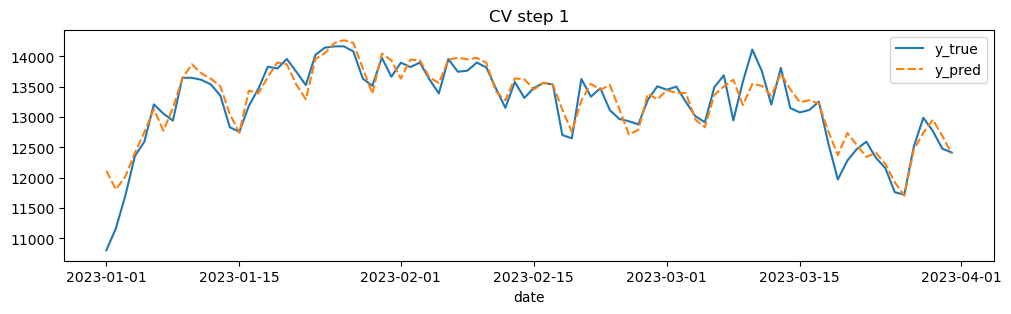

LGBM CV step 1 MAE: 178.668994241208
end train: 2022-06-30 00:00:00, end_valid: 2022-09-30 00:00:00, end_test: 2022-12-31 00:00:00
[100]	valid_0's l2: 85.4077
[200]	valid_0's l2: 81.8299
[300]	valid_0's l2: 81.925
[400]	valid_0's l2: 82.6579
[500]	valid_0's l2: 82.8348


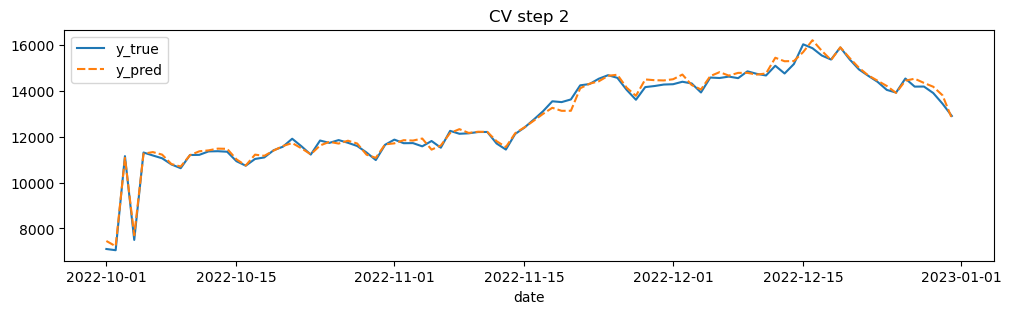

LGBM CV step 2 MAE: 140.84453398982328
end train: 2022-04-30 00:00:00, end_valid: 2022-06-30 00:00:00, end_test: 2022-09-30 00:00:00
[100]	valid_0's l2: 167.013
[200]	valid_0's l2: 163.255
[300]	valid_0's l2: 161.41
[400]	valid_0's l2: 160.326
[500]	valid_0's l2: 160.042
[600]	valid_0's l2: 160.365


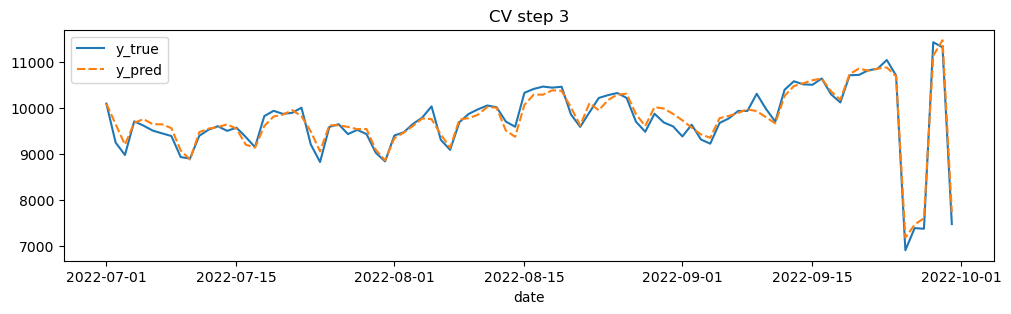

LGBM CV step 3 MAE: 119.0962986864595
end train: 2021-12-31 00:00:00, end_valid: 2022-04-30 00:00:00, end_test: 2022-06-30 00:00:00
[100]	valid_0's l2: 213.59
[200]	valid_0's l2: 210.167
[300]	valid_0's l2: 208.445
[400]	valid_0's l2: 209.329
[500]	valid_0's l2: 208.937


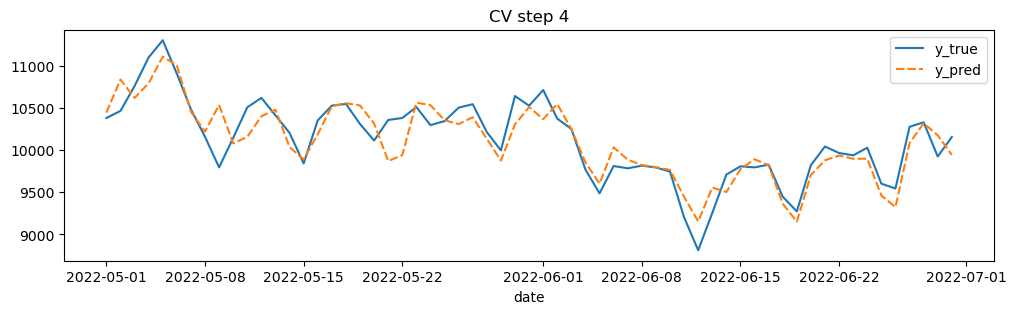

LGBM CV step 4 MAE: 158.6169720166994
end train: 2021-09-30 00:00:00, end_valid: 2021-12-31 00:00:00, end_test: 2022-04-30 00:00:00
[100]	valid_0's l2: 208.049
[200]	valid_0's l2: 204.072
[300]	valid_0's l2: 210.004


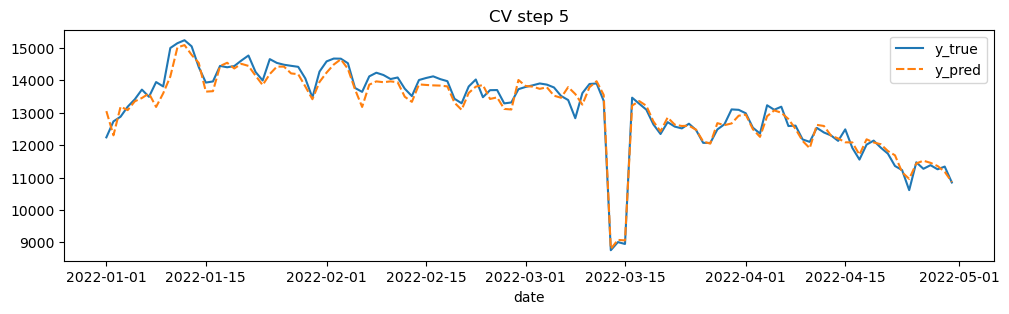

LGBM CV step 5 MAE: 186.98490753743755


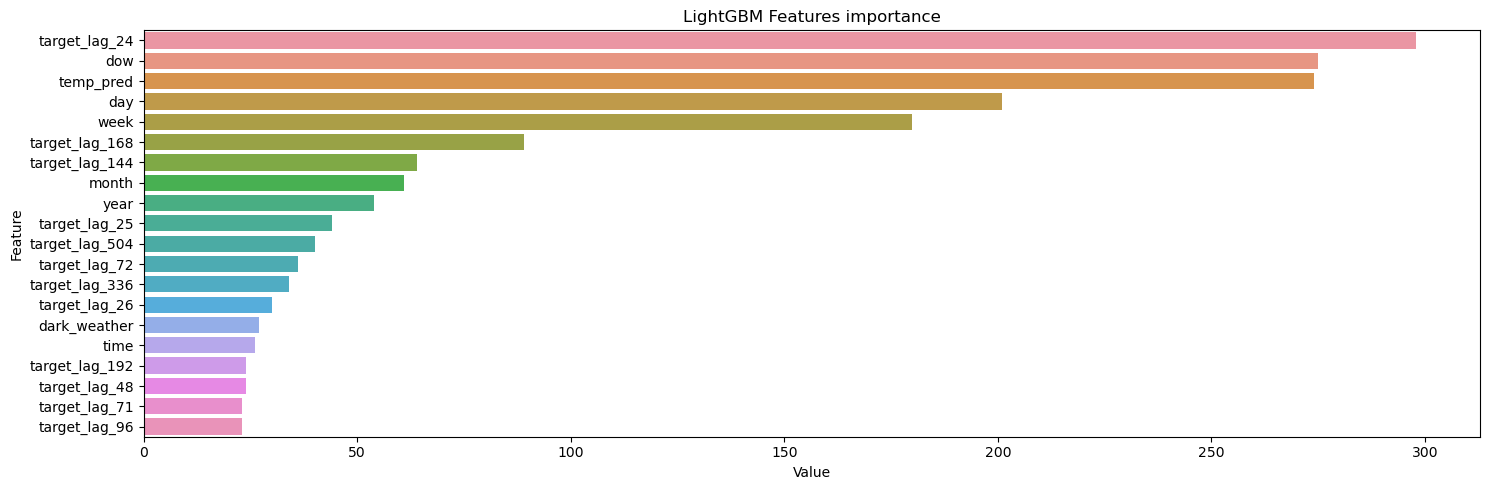

In [15]:
lgbm_maes = lgbm_cross_val(df=with_daylight, cols_to_drop=['date', 'target', 'weather_pred', 'sunrise', 'sunset', 'overcast', 'cloudy', 'rain', 'heavy_rain', 'snow', 'thunder', 'storm', 'light'])

In [16]:
print(f'LGBM mean MAE = {np.mean(lgbm_maes)}')

LGBM mean MAE = 156.84234129432554


Итерация 1

* Только календарные фичи и лаги за 14 дней с шагом 24 часа
* MAE = __193.15255716646837__

Итерация 2

* Плюс прогноз температуры
* MAE = __163.4661175990197__

Итерация 3

* Лаги без шага, все подряд, глубина та же
* MAE = __163.29011103212937__

Итерация 4

* Лаги с шагом в сутки, но за три недели
* MAE = __160.38551212962977__

Итерация 5

* Лаги без шага, все подряд, за три недели
* MAE = __159.3854629473231__

Итерация 6

* Календарные фичи, лаги за 21 день без шага, маркеры плохой погоды (по прогнозу)
* MAE = __160.15958681663875__

Итерация 7

* Календарные фичи, лаги за 21 день без шага, маркеры плохой погоды, маркер светлого времени суток
* MAE = __159.48854635745494__

Итерация 8

* Календарные фичи, лаги за 21 день без шага, маркер светлого времени суток (без маркеров погоды)
* MAE = __158.9678897379294__

Итерация 9

* Календарные фичи, лаги за 21 день без шага, маркер светлого времени суток, маркер темной погоды
* MAE = __159.1095764419__

Итерация 10

* То же, что в прошлой попытке, но без маркера светлого времени
* MAE = __156.84234129432554__

In [17]:
def objective(trial, df=with_daylight, cols_to_drop=['date', 'target', 'weather_pred', 'sunrise', 'sunset', 'overcast', 'cloudy', 'rain', 'heavy_rain', 'snow', 'thunder', 'storm', 'light'], cat_features=[], h=3):
    
    end_train = df['date'].max() - np.timedelta64(h*2, 'M') + pd.offsets.MonthEnd()
    end_valid = df['date'].max() - np.timedelta64(h, 'M') + pd.offsets.MonthEnd()
        
    train = df[df['date'] <= end_train]
    valid = df[(df['date'] > end_train) & (df['date'] <= end_valid)]
    test = df[df['date'] > end_valid]

    X_train = train.drop(cols_to_drop, axis=1)
    y_train = train['target']
    X_valid = valid.drop(cols_to_drop, axis=1)
    y_valid = valid['target']
    X_test = valid.drop(cols_to_drop, axis=1)
    y_test = valid['target']

    eval_set = [(X_valid, y_valid)]

    cat_idx = [X_train.columns.get_loc(col) for col in cat_features]

    for col in cat_features:
        X_train[col] = pd.Categorical(X_train[col])
        X_valid[col] = pd.Categorical(X_valid[col])

    param = {
        'metric': 'mae', 
        'random_state': 26,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.95, step=0.1)
    }
    model = lgbm.LGBMRegressor(**param)  
    
    model.fit(X_train,y_train,categorical_feature=cat_idx,eval_set=eval_set,early_stopping_rounds=100,verbose=500)
    
    preds = model.predict(X_valid)

    trial.set_user_attr(key="best_booster", value=model)
    
    return mean_absolute_error(y_valid, preds)

def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])


if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction='minimize'
    )
    study.optimize(objective, n_trials=10, callbacks=[callback])
    best_model=study.user_attrs["best_booster"]

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-10-20 19:38:01,140] A new study created in memory with name: no-name-d6a27f91-0198-4efd-ab2e-82c05a02c3ba


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.7


[I 2023-10-20 19:38:39,922] Trial 0 finished with value: 8.35837810881694 and parameters: {'reg_alpha': 0.1344454394712998, 'reg_lambda': 0.6755938822042685, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 885, 'min_child_samples': 93, 'feature_fraction': 0.7}. Best is trial 0 with value: 8.35837810881694.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.6000000000000001


[I 2023-10-20 19:39:05,391] Trial 1 finished with value: 8.545766431728552 and parameters: {'reg_alpha': 4.5684852795616315, 'reg_lambda': 0.11540300224386511, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 634, 'min_child_samples': 149, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 8.35837810881694.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.2
[500]	valid_0's l1: 9.78625
[1000]	valid_0's l1: 9.50745


[I 2023-10-20 19:39:25,160] Trial 2 finished with value: 9.498782593083043 and parameters: {'reg_alpha': 0.0028423830846745508, 'reg_lambda': 0.14439013533157607, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 145, 'min_child_samples': 203, 'feature_fraction': 0.2}. Best is trial 0 with value: 8.35837810881694.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


[I 2023-10-20 19:40:01,875] Trial 3 finished with value: 8.535430302749546 and parameters: {'reg_alpha': 0.16926395391786675, 'reg_lambda': 0.40138010306430155, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 816, 'min_child_samples': 154, 'feature_fraction': 0.8}. Best is trial 0 with value: 8.35837810881694.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.30000000000000004
[500]	valid_0's l1: 9.05098


[I 2023-10-20 19:40:26,712] Trial 4 finished with value: 8.995646646907288 and parameters: {'reg_alpha': 1.7136455595308557, 'reg_lambda': 0.6209406346039003, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 217, 'min_child_samples': 205, 'feature_fraction': 0.30000000000000004}. Best is trial 0 with value: 8.35837810881694.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.4
[500]	valid_0's l1: 8.91396


[I 2023-10-20 19:41:44,666] Trial 5 finished with value: 8.902848106384509 and parameters: {'reg_alpha': 0.04131263166694731, 'reg_lambda': 0.15333725686350394, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 511, 'min_child_samples': 59, 'feature_fraction': 0.4}. Best is trial 0 with value: 8.35837810881694.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.6000000000000001


[I 2023-10-20 19:42:00,879] Trial 6 finished with value: 8.869215659022208 and parameters: {'reg_alpha': 7.903817941612179, 'reg_lambda': 1.3239899170948206, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 443, 'min_child_samples': 297, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 8.35837810881694.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[500]	valid_0's l1: 12.7191
[1000]	valid_0's l1: 9.88825
[1500]	valid_0's l1: 9.52831


[I 2023-10-20 19:42:33,482] Trial 7 finished with value: 9.47969992606601 and parameters: {'reg_alpha': 0.05987877397061647, 'reg_lambda': 0.054956819589132525, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 975, 'min_child_samples': 262, 'feature_fraction': 0.2}. Best is trial 0 with value: 8.35837810881694.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.2
[500]	valid_0's l1: 10.0724


[I 2023-10-20 19:43:11,691] Trial 8 finished with value: 10.012012616719524 and parameters: {'reg_alpha': 0.1337602841480717, 'reg_lambda': 0.18012395916269958, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 970, 'min_child_samples': 68, 'feature_fraction': 0.2}. Best is trial 0 with value: 8.35837810881694.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.7


[I 2023-10-20 19:44:22,301] Trial 9 finished with value: 8.356515039779746 and parameters: {'reg_alpha': 9.770425294291131, 'reg_lambda': 3.579832657494365, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 709, 'min_child_samples': 47, 'feature_fraction': 0.7}. Best is trial 9 with value: 8.356515039779746.


Number of finished trials: 10
Best trial: {'reg_alpha': 9.770425294291131, 'reg_lambda': 3.579832657494365, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 709, 'min_child_samples': 47, 'feature_fraction': 0.7}


In [18]:
# study.optimize(objective, n_trials=10, callbacks=[callback])
# best_model=study.user_attrs["best_booster"]

LGBM MAE: 184.78094098745845


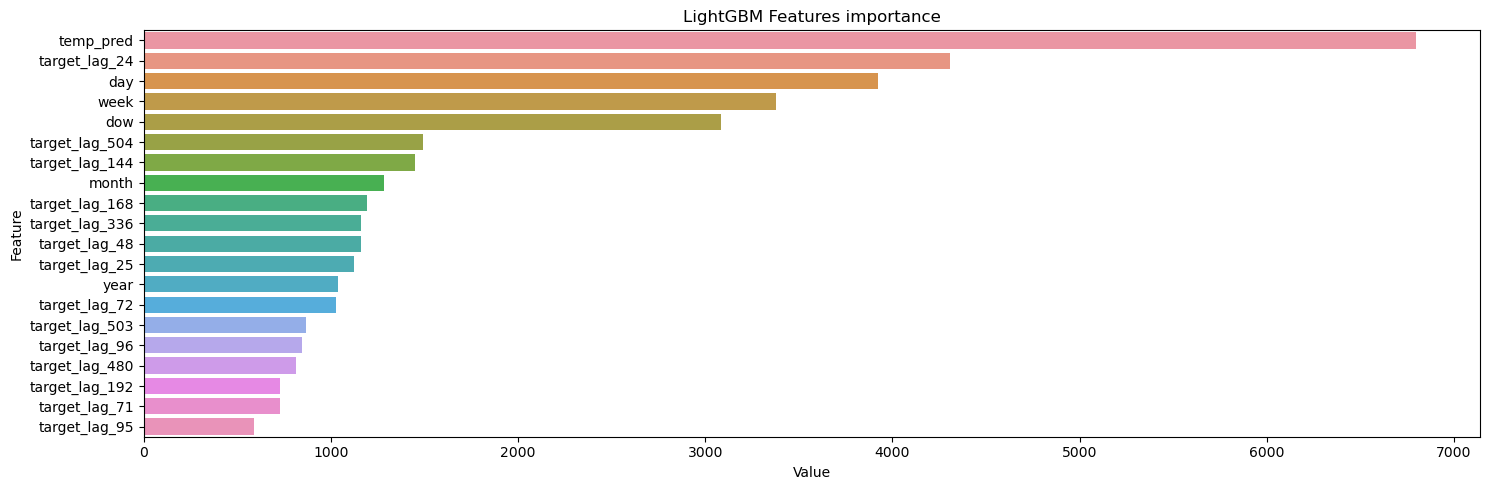

In [20]:
data=with_daylight
cols_to_drop=['date', 'target', 'weather_pred', 'sunrise', 'sunset', 'overcast', 'cloudy', 'rain', 'heavy_rain', 'snow', 'thunder', 'storm', 'light']
cat_features=[]

end_train = data['date'].max() - np.timedelta64(6, 'M') + pd.offsets.MonthEnd()
end_valid = data['date'].max() - np.timedelta64(3, 'M') + pd.offsets.MonthEnd()

train = data[data['date'] <= end_train]
valid = data[(data['date'] > end_train) & (data['date'] <= end_valid)]
test = data[data['date'] > end_valid]

X_train = train.drop(cols_to_drop, axis=1)
y_train = train['target']
X_valid = valid.drop(cols_to_drop, axis=1)
y_valid = valid['target']
X_test = test.drop(cols_to_drop, axis=1)
y_test = test['target']

cat_idx = [X_train.columns.get_loc(col) for col in cat_features]

for col in cat_features:
    X_train[col] = pd.Categorical(X_train[col])
    X_valid[col] = pd.Categorical(X_valid[col])

lgbm_reg = best_model

preds = lgbm_reg.predict(X_test)
preds = pd.DataFrame({'y_pred': preds, 'date': test['date']})        
preds_grouped = preds.groupby('date')['y_pred'].sum()
y_test = pd.DataFrame({'y_test': y_test, 'date': test['date']})
y_test_grouped = y_test.groupby('date')['y_test'].sum()
lgbm_mae = mean_absolute_error(y_test_grouped, preds_grouped)

print(f"LGBM MAE: {lgbm_mae}")

plotImp(lgbm_reg, X_train)